In [6]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import umap
import seaborn as sns

In [7]:
folder_path = r"C:\Users\tere1\OneDrive\Escritorio\TFM\datos_img"
# Cargar las características normalizadas por Z-score
df_shape_z = pd.read_csv(os.path.join(folder_path, "features_shape_zscore.csv"))
# Cargar las características normalizadas por Min-Max
df_shape_mm = pd.read_csv(os.path.join(folder_path, "features_shape_minmax.csv"))

In [8]:
#Se eliminan los datos no numéricos: 'label' y 'filename'
df_shape_z_cl= df_shape_z.drop(columns=['filename', 'label'])

se va a buscar el que podría ser el mejor numero de clusteres usando BIC (Bayesian Information Criterion) y AIC (Akaike Information Criterion)

Text(0.5, 1.0, 'BIC and AIC Scores Per Number Of Clusters')

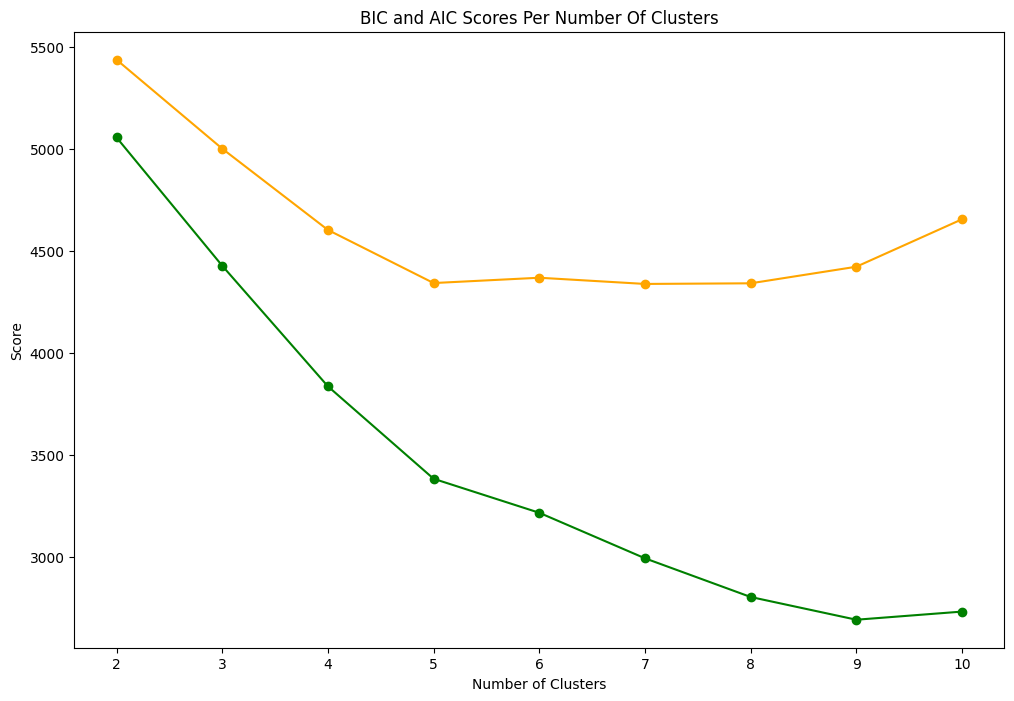

In [9]:
# Set up a range of cluster numbers to try
n_range = range(2,11)
# Create empty lists to store the BIC and AIC values
bic_score = []
aic_score = []

# Loop through the range and fit a model
for n in n_range:
    gm = GaussianMixture(n_components=n, 
                         random_state=123, 
                         n_init=10)
    gm.fit(df_shape_z_cl)
    
    # Append the BIC and AIC to the respective lists
    bic_score.append(gm.bic(df_shape_z_cl))
    aic_score.append(gm.aic(df_shape_z_cl))
    
# Plot the BIC and AIC values together
fig, ax = plt.subplots(figsize=(12,8),nrows=1)
ax.plot(n_range, bic_score, '-o', color='orange')
ax.plot(n_range, aic_score, '-o', color='green')
ax.set(xlabel='Number of Clusters', ylabel='Score')
ax.set_xticks(n_range)
ax.set_title('BIC and AIC Scores Per Number Of Clusters')



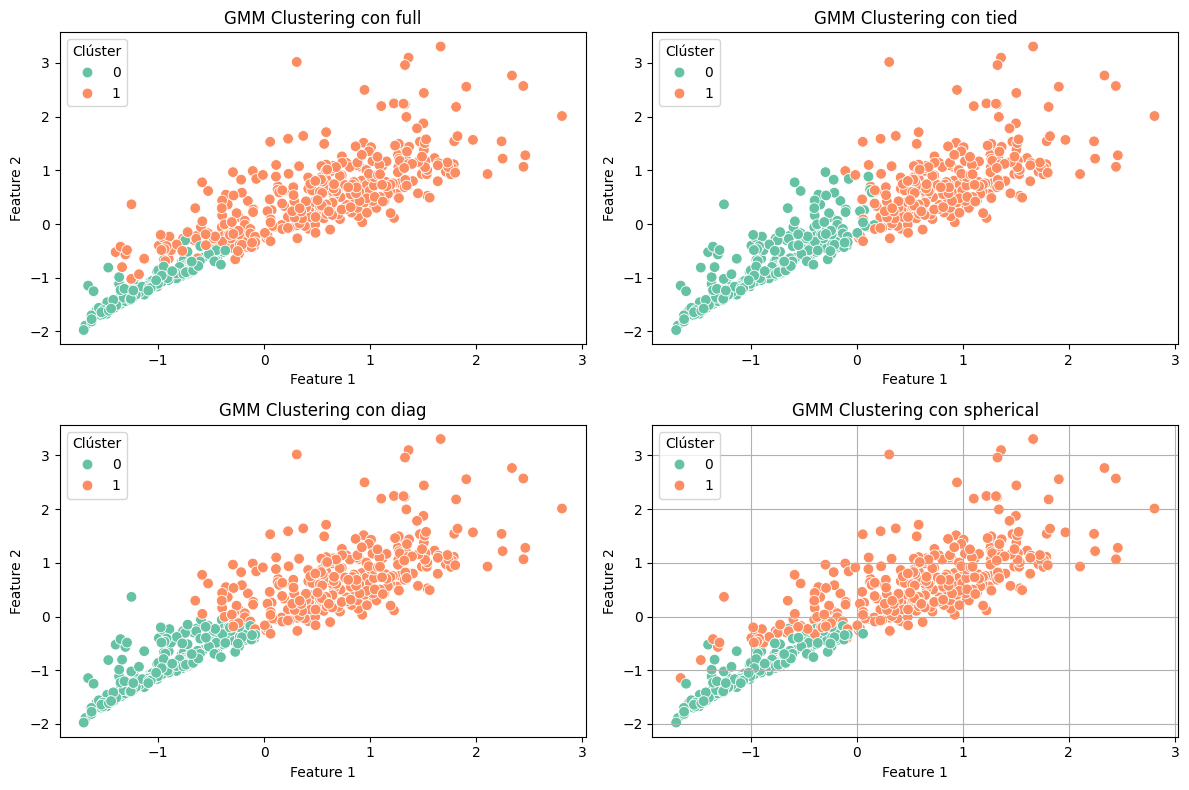

In [10]:
# GMM con distintas covarianzas
n_components = 2
covariance_types = ['full', 'tied', 'diag', 'spherical']
gmm_models_z = {cov_type: GaussianMixture(n_components=n_components, covariance_type=cov_type, random_state=42)
                for cov_type in covariance_types}

# Entrenar modelos
for cov_type, gmm_model in gmm_models_z.items():
    gmm_model.fit(df_shape_z_cl)

# Predicciones
predictions_z = {cov_type: gmm_model.predict(df_shape_z_cl)
                 for cov_type, gmm_model in gmm_models_z.items()}

# Visualización en el espacio original (2 primeras características)
plt.figure(figsize=(12, 8))
for i, cov_type in enumerate(covariance_types, 1):
    df_plot = pd.DataFrame({
        'Feature 1': df_shape_z_cl.iloc[:, 0],
        'Feature 2': df_shape_z_cl.iloc[:, 1],
        'Cluster': predictions_z[cov_type].astype(str)
    })

    plt.subplot(2, 2, i)
    sns.scatterplot(
        data=df_plot,
        x='Feature 1',
        y='Feature 2',
        hue='Cluster',
        palette='Set2',
        s=60,
        edgecolor='white',
        alpha=1
    )
    plt.title(f'GMM Clustering con {cov_type}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend(title='Clúster', loc='best')

plt.tight_layout()
plt.grid(True)
plt.show()

In [11]:
print("\n--- Silhouette Scores por tipo de covarianza ---")
for cov_type in covariance_types:
    score = silhouette_score(df_shape_z_cl, predictions_z[cov_type])
    print(f"{cov_type.capitalize()} covariance: Silhouette Score = {score:.3f}")


--- Silhouette Scores por tipo de covarianza ---
Full covariance: Silhouette Score = 0.310
Tied covariance: Silhouette Score = 0.311
Diag covariance: Silhouette Score = 0.332
Spherical covariance: Silhouette Score = 0.330


In [12]:

df_shape_z['predictions_z_full'] = predictions_z['full']
df_shape_z['predictions_z_tied'] = predictions_z['tied']
df_shape_z['predictions_z_diag'] = predictions_z['diag']
df_shape_z['predictions_z_spherical'] = predictions_z['spherical']

# Crear las tablas de contingencia para cada tipo de covarianza
contingency_full = pd.crosstab(df_shape_z['label'], df_shape_z['predictions_z_full'], rownames=['Label'], colnames=['Cluster (full)'])
contingency_tied = pd.crosstab(df_shape_z['label'], df_shape_z['predictions_z_tied'], rownames=['Label'], colnames=['Cluster (tied)'])
contingency_diag = pd.crosstab(df_shape_z['label'], df_shape_z['predictions_z_diag'], rownames=['Label'], colnames=['Cluster (diag)'])
contingency_spherical = pd.crosstab(df_shape_z['label'], df_shape_z['predictions_z_spherical'], rownames=['Label'], colnames=['Cluster (spherical)'])

# Mostrar las tablas de contingencia
print("Contingency Table for Full Covariance:")
print(contingency_full)

print("\nContingency Table for Tied Covariance:")
print(contingency_tied)

print("\nContingency Table for Diagonal Covariance:")
print(contingency_diag)

print("\nContingency Table for Spherical Covariance:")
print(contingency_spherical)

Contingency Table for Full Covariance:
Cluster (full)    0    1
Label                   
higher_than       6  262
smaller_than    172   97

Contingency Table for Tied Covariance:
Cluster (tied)    0    1
Label                   
higher_than      29  239
smaller_than    252   17

Contingency Table for Diagonal Covariance:
Cluster (diag)    0    1
Label                   
higher_than      17  251
smaller_than    228   41

Contingency Table for Spherical Covariance:
Cluster (spherical)    0    1
Label                        
higher_than           15  253
smaller_than         197   72


c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


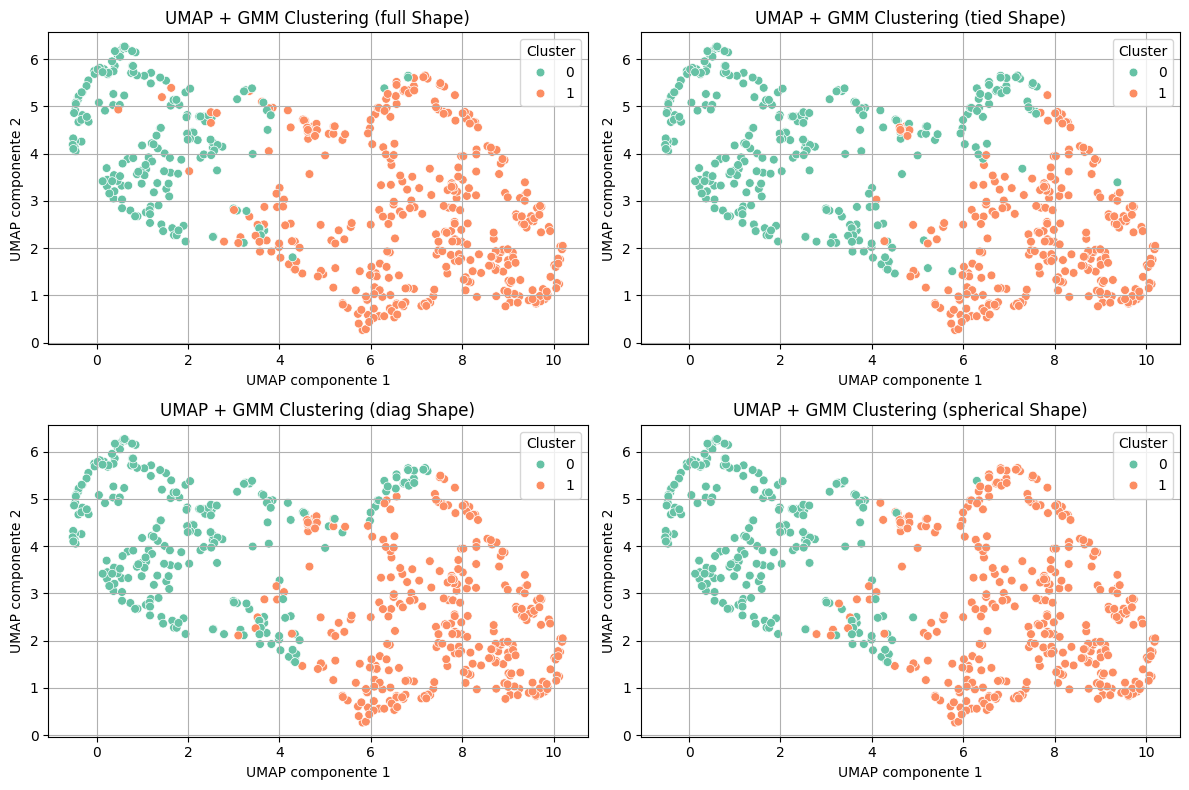

In [15]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_shape_z_cl)

plt.figure(figsize=(12, 8))

for i, (cov_type, gmm_model) in enumerate(gmm_models_z.items(), 1):
    plt.subplot(2, 2, i)
    
    clusters = predictions_z[cov_type]
    unique_clusters = np.unique(clusters)
    n_clusters = len(unique_clusters)
    
    # Mapear clusters a strings para seaborn
    df_plot = pd.DataFrame({
        'UMAP 1': embedding[:, 0],
        'UMAP 2': embedding[:, 1],
        'Cluster': clusters.astype(str)
    })
    
    # Paleta categórica con n colores
    palette = sns.color_palette("Set2", n_colors=n_clusters)
    
    sns.scatterplot(
        data=df_plot,
        x='UMAP 1',
        y='UMAP 2',
        hue='Cluster',
        palette=palette,
        edgecolor='white',
        s=40,
        alpha=1,
        legend='full'
    )
    
    plt.title(f'UMAP + GMM Clustering ({cov_type} Shape)')
    plt.xlabel('UMAP componente 1')
    plt.ylabel('UMAP componente 2')
    plt.grid(True)

plt.tight_layout()
plt.show()

minmax

In [ ]:
#Se eliminan los datos no numéricos: 'label' y 'filename'
df_shape_mm_cl= df_shape_mm.drop(columns=['filename', 'label'])

Text(0.5, 1.0, 'BIC and AIC Scores Per Number Of Clusters')

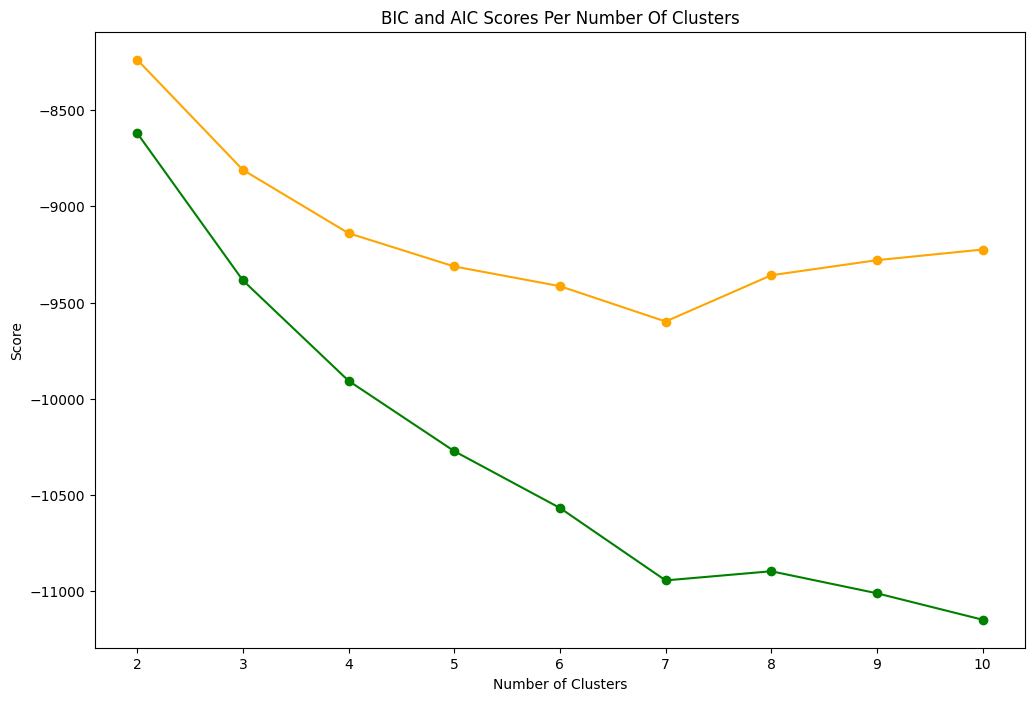

In [ ]:
# Set up a range of cluster numbers to try
n_range = range(2,11)
# Create empty lists to store the BIC and AIC values
bic_score = []
aic_score = []

# Loop through the range and fit a model
for n in n_range:
    gm = GaussianMixture(n_components=n, 
                         random_state=123, 
                         n_init=10)
    gm.fit(df_shape_mm_cl)
    
    # Append the BIC and AIC to the respective lists
    bic_score.append(gm.bic(df_shape_mm_cl))
    aic_score.append(gm.aic(df_shape_mm_cl))
    
# Plot the BIC and AIC values together
fig, ax = plt.subplots(figsize=(12,8),nrows=1)
ax.plot(n_range, bic_score, '-o', color='orange')
ax.plot(n_range, aic_score, '-o', color='green')
ax.set(xlabel='Number of Clusters', ylabel='Score')
ax.set_xticks(n_range)
ax.set_title('BIC and AIC Scores Per Number Of Clusters')

In [ ]:
n_components = 2  # Number of clusters
covariance_types = ['full', 'tied', 'diag', 'spherical']

gmm_models_mm = {cov_type: GaussianMixture(n_components=n_components, covariance_type=cov_type)
              for cov_type in covariance_types}

for cov_type, gmm_model in gmm_models_mm.items():
    gmm_model.fit(df_shape_mm_cl)


In [ ]:
covariances_mm = {cov_type: gmm_model.covariances_
               for cov_type, gmm_model in gmm_models_mm.items()}

In [ ]:
predictions_mm = {cov_type: gmm_model.predict(df_shape_mm_cl)
               for cov_type, gmm_model in gmm_models_mm.items()}

Covariance Matrix (full - Component):
[[ 7.63980816e-03  6.18613851e-03 -1.74548526e-03 -1.99750858e-03
   5.02335773e-05  9.43665470e-04  8.01904648e-03  9.39964264e-03]
 [ 6.18613851e-03  7.15890919e-03  6.06669047e-04 -7.06113846e-03
  -6.92493102e-03  7.74805000e-04  8.25354546e-03  8.41942369e-03]
 [-1.74548526e-03  6.06669047e-04  3.84415368e-02 -9.09136863e-03
  -7.40679593e-03 -2.74454769e-03  6.18895728e-03 -8.27596356e-03]
 [-1.99750858e-03 -7.06113846e-03 -9.09136863e-03  2.66986897e-02
   2.13855678e-02  2.75093548e-03 -8.13188548e-03 -4.09741514e-03]
 [ 5.02335773e-05 -6.92493102e-03 -7.40679593e-03  2.13855678e-02
   2.66456247e-02 -1.00962137e-03 -5.98715844e-03 -2.49385032e-03]
 [ 9.43665470e-04  7.74805000e-04 -2.74454769e-03  2.75093548e-03
  -1.00962137e-03  8.38213625e-02 -2.07990106e-04  8.64171038e-04]
 [ 8.01904648e-03  8.25354546e-03  6.18895728e-03 -8.13188548e-03
  -5.98715844e-03 -2.07990106e-04  1.14519795e-02  9.36980311e-03]
 [ 9.39964264e-03  8.41942369e-

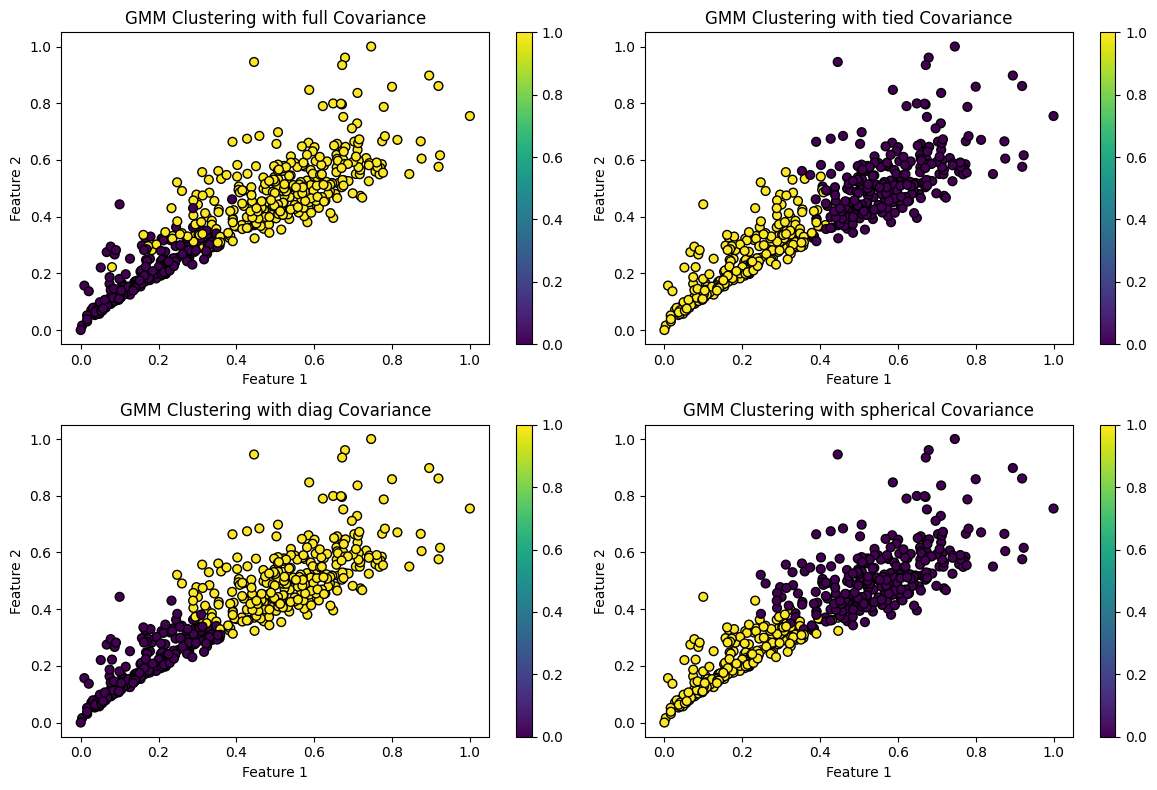

In [ ]:
plt.figure(figsize=(12, 8))

for i, (cov_type, gmm_model) in enumerate(gmm_models_mm.items(), 1):
    plt.subplot(2, 2, i)
    plt.scatter(df_shape_mm_cl.iloc[:, 0], df_shape_mm_cl.iloc[:, 1], c=predictions_mm[cov_type], cmap='viridis', edgecolors='k', s=40)
    plt.title(f'GMM Clustering with {cov_type} Covariance')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar()
    
    print(f'Covariance Matrix ({cov_type} - Component):\n{covariances_mm[cov_type][0]}')

plt.tight_layout()
plt.show()

In [ ]:
print("\n--- Silhouette Scores por tipo de covarianza ---")
for cov_type in covariance_types:
    score = silhouette_score(df_shape_mm_cl, predictions_mm[cov_type])
    print(f"{cov_type.capitalize()} covariance: Silhouette Score = {score:.3f}")


--- Silhouette Scores por tipo de covarianza ---
Full covariance: Silhouette Score = 0.309
Tied covariance: Silhouette Score = 0.309
Diag covariance: Silhouette Score = 0.323
Spherical covariance: Silhouette Score = 0.324


c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


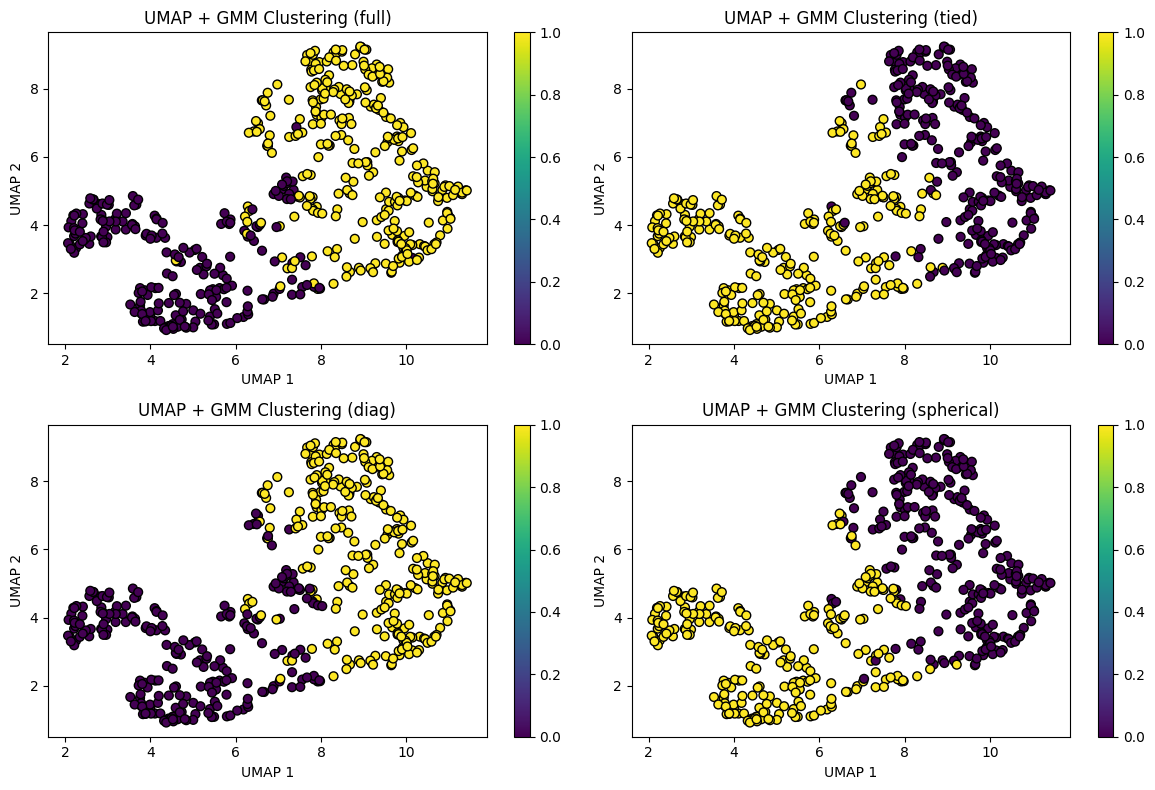

In [ ]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_shape_mm_cl)

plt.figure(figsize=(12, 8))

for i, (cov_type, gmm_model) in enumerate(gmm_models_mm.items(), 1):
    plt.subplot(2, 2, i)
    plt.scatter(embedding[:, 0], embedding[:, 1], 
                c=predictions_mm[cov_type], 
                cmap='viridis', edgecolors='k', s=40)
    plt.title(f'UMAP + GMM Clustering ({cov_type})')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.colorbar()

plt.tight_layout()
plt.show()


In [ ]:
df_shape_mm['predictions_z_full'] = predictions_mm['full']
df_shape_mm['predictions_z_tied'] = predictions_mm['tied']
df_shape_mm['predictions_z_diag'] = predictions_mm['diag']
df_shape_mm['predictions_z_spherical'] = predictions_mm['spherical']

# Crear las tablas de contingencia para cada tipo de covarianza
contingency_full = pd.crosstab(df_shape_mm['label'], df_shape_mm['predictions_z_full'], rownames=['Label'], colnames=['Cluster (full)'])
contingency_tied = pd.crosstab(df_shape_mm['label'], df_shape_mm['predictions_z_tied'], rownames=['Label'], colnames=['Cluster (tied)'])
contingency_diag = pd.crosstab(df_shape_mm['label'], df_shape_mm['predictions_z_diag'], rownames=['Label'], colnames=['Cluster (diag)'])
contingency_spherical = pd.crosstab(df_shape_mm['label'], df_shape_mm['predictions_z_spherical'], rownames=['Label'], colnames=['Cluster (spherical)'])

# Mostrar las tablas de contingencia
print("Contingency Table for Full Covariance:")
print(contingency_full)

print("\nContingency Table for Tied Covariance:")
print(contingency_tied)

print("\nContingency Table for Diagonal Covariance:")
print(contingency_diag)

print("\nContingency Table for Spherical Covariance:")
print(contingency_spherical)

Contingency Table for Full Covariance:
Cluster (full)    0    1
Label                   
higher_than      14  254
smaller_than    212   57

Contingency Table for Tied Covariance:
Cluster (tied)    0    1
Label                   
higher_than     239   29
smaller_than     17  252

Contingency Table for Diagonal Covariance:
Cluster (diag)    0    1
Label                   
higher_than      20  248
smaller_than    229   40

Contingency Table for Spherical Covariance:
Cluster (spherical)    0    1
Label                        
higher_than          244   24
smaller_than          36  233


Con todos los tipos de covarianza se consiguen dos clusteres bien equilibrados  aunque no muy puros, ya que están algo juntos Para verlos mejor se podría usar umap y después con esos resultados aplicar el clustering como se ha hecho antes.